## Importing the required libraries

In [1]:

!pip install librosa==0.8.1
!pip install keras

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
#from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('Data/')

In [5]:
type(mylist)

list

In [6]:
print(mylist[400])

03-02-03-02-01-02-12.wav


In [7]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [8]:
data, sampling_rate = librosa.load('Data/f11 (2).wav')

Populating the interactive namespace from numpy and matplotlib


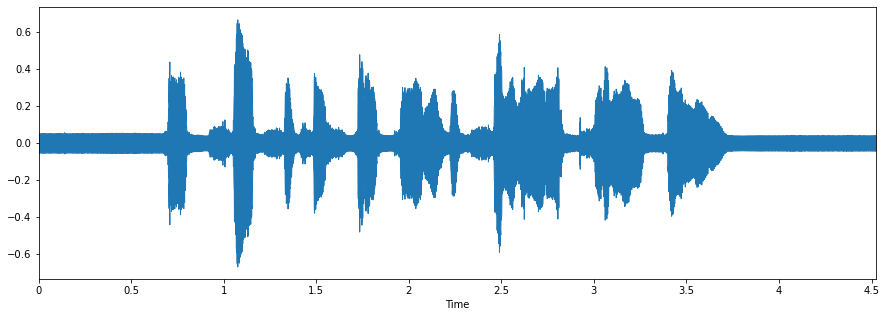

In [9]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

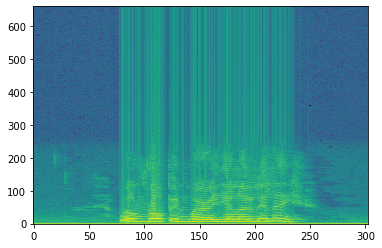

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('Data/f10 (2).wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [12]:
labels = pd.DataFrame(feeling_list)

In [13]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [14]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('Data/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [15]:
df[:5]

,feature
0,"[-61.54348, -61.67079, -61.66402, -61.67609, -..."
1,"[-59.343815, -59.343815, -59.343815, -59.34381..."
2,"[-48.954903, -48.82906, -49.682064, -52.032497..."
3,"[-60.076115, -60.313362, -59.85728, -57.803627..."
4,"[-60.015438, -62.687523, -65.48864, -60.481686..."


In [16]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [17]:
newdf = pd.concat([df3,labels], axis=1)

In [18]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [19]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-61.543480,-61.670792,-61.664021,-61.676090,-59.628006,-58.578781,-60.385185,-60.371346,-59.209568,-59.794174,...,-32.030075,-28.537540,-27.504944,-26.420601,-27.831970,-28.752380,-28.787106,-21.614941,-17.305622,male_calm
1,-59.343815,-59.343815,-59.343815,-59.343815,-59.343815,-59.343815,-59.343815,-59.343815,-59.343815,-59.343815,...,-42.968018,-43.957214,-44.208229,-43.752216,-42.169685,-43.242554,-43.617336,-20.664318,-12.429281,female_calm
2,-48.954903,-48.829060,-49.682064,-52.032497,-48.399529,-47.976292,-49.651043,-51.261330,-49.758415,-50.975594,...,-23.577993,-24.114504,-22.896618,-22.713051,-24.840162,-27.322853,-28.557924,-28.593208,-25.436642,male_calm
3,-60.076115,-60.313362,-59.857281,-57.803627,-58.947990,-59.264259,-57.992954,-57.402184,-57.060040,-57.166325,...,-42.777756,-40.189968,-38.820744,-39.011463,-41.907833,-42.494225,-43.464848,-36.842045,-29.899763,female_calm
4,-60.015438,-62.687523,-65.488640,-60.481686,-60.038582,-64.788902,-66.386765,-61.152958,-58.950161,-59.597675,...,-43.593582,-42.289333,-42.089737,-42.331387,-40.318398,-37.839176,-35.933887,-32.706936,-28.033237,male_calm


In [20]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
903,-51.523880,-51.921402,-52.180885,-49.994858,-49.482639,-48.048374,-47.784798,-47.361305,-47.557716,-49.408180,...,-25.280239,-25.824177,-27.198555,-28.584293,-30.707245,-32.649132,-32.237167,-25.594715,-19.605133,male_fearful
53,-51.353168,-51.740520,-51.827328,-51.899006,-53.882393,-55.149002,-56.019772,-57.153866,-53.584995,-52.552132,...,-44.521034,-48.111431,-48.306595,-49.382626,-49.741917,-47.964462,-49.856567,-48.341484,-48.576233,female_calm
982,-25.215376,-25.368589,-26.160130,-24.963383,-26.241587,-26.541342,-26.930876,-27.198174,-25.941088,-26.378038,...,-9.468451,-10.316779,-10.013561,-10.231319,-13.142212,-14.014775,-16.322588,-17.319080,-18.697050,male_fearful
505,-57.336483,-57.381252,-58.548073,-58.756741,-57.836906,-57.324844,-57.320335,-57.336483,-57.336483,-57.336483,...,-46.780796,-46.658913,-44.289108,-44.066196,-43.572178,-44.435234,-47.066895,-26.346657,-18.719433,female_sad
282,-55.103592,-55.769173,-55.018192,-54.408699,-55.773617,-56.602261,-56.308151,-55.360031,-55.885071,-56.531075,...,-31.024158,-30.602755,-30.349287,-29.535412,-29.935190,-30.373552,-30.596575,-26.591434,-21.097120,male_happy
31,-63.390598,-63.390598,-63.390598,-63.390598,-63.390598,-63.390598,-63.390598,-63.390598,-63.390598,-63.390598,...,-35.848454,-36.053364,-36.651665,-35.653763,-36.421925,-36.802597,-36.183548,-30.296295,-24.854063,male_calm
718,-45.025997,-44.315605,-45.234440,-45.114536,-44.260235,-44.065666,-45.053574,-43.815830,-44.057896,-45.419773,...,-38.057056,-37.727177,-40.300102,-38.876087,-39.292042,-40.980392,-43.861668,-32.717308,-26.423119,female_angry
712,-48.076767,-48.076767,-48.100731,-47.918251,-47.799393,-47.872799,-47.933769,-48.198570,-48.188786,-48.375717,...,-32.747898,-31.729889,-30.302938,-30.244652,-24.721478,-19.259583,-19.558739,-15.127843,-8.727499,female_angry
512,-59.062584,-60.086525,-58.531914,-57.556648,-58.144001,-58.897667,-58.728691,-56.580570,-55.314987,-55.293453,...,-41.332642,-38.404083,-37.024551,-39.249397,-42.131851,-41.994846,-44.687199,-45.026985,-43.308449,male_sad
850,-48.815838,-48.910042,-49.021248,-49.165298,-49.348572,-49.343559,-49.371117,-49.278469,-49.048557,-49.180176,...,-36.488667,-33.426521,-28.496386,-30.616085,-36.612564,-35.320637,-36.579056,-32.145168,-25.398964,female_fearful


In [21]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [22]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [23]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
737,-59.096523,-58.763138,-57.290226,-56.930542,-57.100471,-56.840218,-56.848763,-56.262856,-56.640541,-56.789005,...,-43.134834,-44.752434,-44.103577,-43.150925,-42.773235,-43.082241,-44.187763,-29.357054,-21.944405,female_fearful
515,-50.286255,-49.724400,-49.976826,-50.427505,-50.694954,-48.572578,-48.053642,-48.341431,-48.119637,-47.071346,...,-42.152061,-43.022636,-43.518490,-43.952244,-44.829636,-43.095333,-43.148479,-26.332916,-18.617641,female_sad
89,-58.814072,-58.282127,-56.633705,-57.086266,-58.576939,-54.509178,-52.848404,-54.128250,-54.700108,-55.352127,...,-33.570538,-32.412411,-31.657452,-31.982134,-30.941526,-31.004650,-31.953651,-23.500010,-19.241716,male_calm
168,-48.268536,-48.011070,-46.744419,-47.979622,-48.268536,-48.268536,-47.748024,-46.810032,-45.310917,-46.179482,...,-40.735062,-40.126408,-40.980343,-40.771294,-40.579208,-39.446220,-38.823509,-17.664427,-9.432464,female_calm
381,-59.350910,-59.350910,-59.350910,-59.350910,-59.350910,-59.350910,-59.350910,-59.367348,-59.392570,-59.289837,...,-36.547501,-38.463486,-38.758957,-38.575546,-37.918926,-39.899094,-39.653179,-27.084745,-19.162296,female_sad
77,-43.806026,-43.199203,-45.087540,-46.223671,-45.744663,-44.365288,-43.415630,-43.436150,-44.733871,-46.075466,...,-38.673962,-38.202076,-37.932217,-37.384682,-37.667339,-36.904549,-35.039646,-25.619473,-18.203636,female_calm
130,-52.114216,-50.145447,-50.869038,-52.819237,-51.363804,-50.287815,-51.586422,-49.915054,-49.877548,-49.592834,...,-27.575777,-25.772123,-25.250448,-26.078390,-25.285034,-25.089582,-26.082943,-19.536814,-14.841826,male_calm
341,-47.882137,-46.972515,-47.257839,-48.225971,-48.884853,-49.917412,-49.917412,-48.567257,-48.635536,-49.502403,...,-23.541649,-22.830935,-22.786213,-23.402178,-23.572350,-25.692913,-25.498234,-19.025398,-14.156981,male_happy
1122,-24.001617,-23.905344,-24.780107,-24.695984,-24.413862,-24.512388,-24.231667,-24.735477,-23.975281,-23.680199,...,-25.926847,-25.274954,-25.135550,-24.424959,-25.543886,-25.174559,-24.991140,-27.798061,-26.376648,male_sad
1076,-32.891754,-28.499281,-26.036024,-25.475706,-25.329830,-25.574587,-26.843117,-27.700153,-27.972561,-30.287527,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_happy


In [24]:
trainfeatures = train.iloc[:, :-1]

In [25]:
trainlabel = train.iloc[:, -1:]

In [26]:
testfeatures = test.iloc[:, :-1]

In [27]:
testlabel = test.iloc[:, -1:]

In [28]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\nit16\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [29]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
X_train.shape

(916, 216)

## Changing dimension for CNN model

In [32]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [33]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
from tensorflow import keras
from keras import optimizers
opt = keras.optimizers.RMSprop(learning_rate=0.00001,decay=1e-6)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout (Dropout)           (None, 216, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 128)          0         
 )                                                               
                                                        

In [35]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [128]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
58/58 [==============================] - 3s 50ms/step - loss: 0.1442 - accuracy: 0.9591 - val_loss: 0.0404 - val_accuracy: 0.9826
Epoch 2/200
58/58 [==============================] - 3s 53ms/step - loss: 0.1149 - accuracy: 0.9688 - val_loss: 0.0513 - val_accuracy: 0.9783
Epoch 3/200
58/58 [==============================] - 4s 61ms/step - loss: 0.1219 - accuracy: 0.9677 - val_loss: 0.0489 - val_accuracy: 0.9739
Epoch 4/200
58/58 [==============================] - 3s 55ms/step - loss: 0.1023 - accuracy: 0.9688 - val_loss: 0.0496 - val_accuracy: 0.9739
Epoch 5/200
58/58 [==============================] - 3s 46ms/step - loss: 0.1023 - accuracy: 0.9688 - val_loss: 0.0409 - val_accuracy: 0.9826
Epoch 6/200
58/58 [==============================] - 3s 51ms/step - loss: 0.1124 - accuracy: 0.9709 - val_loss: 0.0550 - val_accuracy: 0.9652
Epoch 7/200
58/58 [==============================] - 3s 58ms/step - loss: 0.1092 - accuracy: 0.9612 - val_loss: 0.0371 - val_accuracy: 0.9913
Epoch 

58/58 [==============================] - 3s 47ms/step - loss: 0.0346 - accuracy: 0.9935 - val_loss: 0.1004 - val_accuracy: 0.9522
Epoch 116/200
58/58 [==============================] - 3s 47ms/step - loss: 0.0246 - accuracy: 0.9957 - val_loss: 0.0908 - val_accuracy: 0.9565
Epoch 117/200
58/58 [==============================] - 3s 50ms/step - loss: 0.0222 - accuracy: 0.9968 - val_loss: 0.0780 - val_accuracy: 0.9652
Epoch 118/200
58/58 [==============================] - 3s 51ms/step - loss: 0.0248 - accuracy: 0.9935 - val_loss: 0.0940 - val_accuracy: 0.9609
Epoch 119/200
58/58 [==============================] - 3s 53ms/step - loss: 0.0336 - accuracy: 0.9903 - val_loss: 0.0804 - val_accuracy: 0.9652
Epoch 120/200
58/58 [==============================] - 3s 50ms/step - loss: 0.0189 - accuracy: 0.9989 - val_loss: 0.0885 - val_accuracy: 0.9609
Epoch 121/200
58/58 [==============================] - 3s 50ms/step - loss: 0.0255 - accuracy: 0.9914 - val_loss: 0.1049 - val_accuracy: 0.9522
Epoch 

Epoch 172/200
58/58 [==============================] - 3s 48ms/step - loss: 0.0269 - accuracy: 0.9925 - val_loss: 0.1033 - val_accuracy: 0.9565
Epoch 173/200
58/58 [==============================] - 3s 49ms/step - loss: 0.0169 - accuracy: 0.9957 - val_loss: 0.0847 - val_accuracy: 0.9652
Epoch 174/200
58/58 [==============================] - 3s 52ms/step - loss: 0.0204 - accuracy: 0.9957 - val_loss: 0.1090 - val_accuracy: 0.9609
Epoch 175/200
58/58 [==============================] - 3s 48ms/step - loss: 0.0222 - accuracy: 0.9968 - val_loss: 0.0869 - val_accuracy: 0.9739
Epoch 176/200
58/58 [==============================] - 3s 50ms/step - loss: 0.0164 - accuracy: 0.9968 - val_loss: 0.1064 - val_accuracy: 0.9522
Epoch 177/200
58/58 [==============================] - 3s 48ms/step - loss: 0.0139 - accuracy: 0.9989 - val_loss: 0.1206 - val_accuracy: 0.9609
Epoch 178/200
58/58 [==============================] - 3s 47ms/step - loss: 0.0198 - accuracy: 0.9946 - val_loss: 0.1067 - val_accuracy:

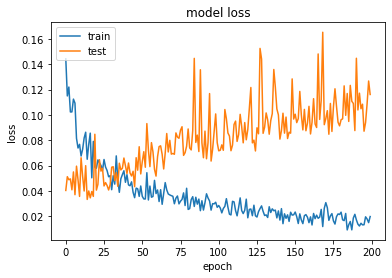

In [129]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [130]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\nit16\Desktop\MajorProject\Speech-Emotion-Analyzer-master\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection_Model.h5 


In [131]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [36]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 98.76%


## Predicting emotions on the test data

In [37]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

8/8 [==============================] - 1s 36ms/step


In [38]:
preds

array([[3.0837369e-13, 1.4464848e-17, 2.8771183e-24, ..., 9.9989378e-01,
        1.1821840e-06, 6.4624605e-06],
       [3.0409586e-09, 9.9936551e-01, 6.3302100e-04, ..., 2.0741925e-13,
        9.0518222e-17, 4.8977651e-13],
       [4.9737000e-08, 5.9787178e-04, 2.4230949e-05, ..., 3.5909649e-20,
        3.5500333e-14, 1.0394322e-13],
       ...,
       [3.8457912e-08, 9.9937695e-01, 1.1710184e-07, ..., 1.7404237e-16,
        1.0365553e-14, 7.5165595e-13],
       [5.2839304e-25, 0.0000000e+00, 6.2774778e-33, ..., 1.3751790e-06,
        1.2343603e-11, 1.3374662e-09],
       [9.0297209e-07, 3.3656042e-04, 1.6787788e-03, ..., 9.3338006e-19,
        1.5683922e-17, 1.2401959e-14]], dtype=float32)

In [39]:
preds1=preds.argmax(axis=1)

In [40]:
preds1

array([7, 1, 4, 8, 6, 0, 9, 2, 9, 8, 1, 8, 6, 6, 5, 1, 5, 9, 7, 9, 0, 2,
       7, 1, 5, 7, 2, 8, 9, 2, 8, 8, 4, 5, 6, 9, 6, 8, 7, 9, 8, 8, 9, 9,
       3, 9, 3, 8, 8, 7, 8, 2, 1, 5, 2, 7, 1, 3, 9, 9, 9, 6, 1, 8, 5, 5,
       4, 6, 2, 2, 7, 9, 6, 7, 5, 7, 0, 9, 7, 9, 4, 5, 5, 4, 3, 7, 1, 7,
       5, 6, 8, 8, 1, 7, 1, 8, 3, 3, 8, 9, 3, 5, 3, 9, 3, 2, 8, 4, 9, 8,
       5, 8, 4, 1, 8, 0, 5, 5, 4, 4, 4, 5, 5, 8, 1, 8, 0, 3, 8, 7, 1, 3,
       2, 7, 3, 0, 3, 1, 9, 7, 6, 5, 8, 1, 3, 5, 9, 2, 4, 5, 3, 9, 8, 8,
       7, 9, 7, 1, 9, 0, 5, 7, 7, 7, 7, 7, 1, 0, 8, 6, 0, 8, 6, 5, 5, 7,
       1, 9, 3, 6, 7, 2, 1, 1, 2, 8, 9, 6, 6, 9, 9, 3, 5, 3, 4, 0, 4, 6,
       1, 9, 0, 5, 8, 3, 9, 3, 5, 9, 2, 4, 5, 1, 4, 0, 5, 2, 5, 1, 3, 9,
       5, 6, 7, 6, 7, 0, 4, 8, 4, 0, 3, 9, 3, 4, 1, 7, 8, 7, 9, 1, 5, 4],
      dtype=int64)

In [41]:
abc = preds1.astype(int).flatten()

In [42]:
predictions = (lb.inverse_transform((abc)))

In [43]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_fearful
1,female_calm
2,female_sad
3,male_happy
4,male_calm
5,female_angry
6,male_sad
7,female_fearful
8,male_sad
9,male_happy


In [44]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [45]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_fearful
1,female_calm
2,female_sad
3,male_happy
4,male_calm
5,female_angry
6,male_sad
7,female_fearful
8,male_sad
9,male_happy


In [46]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [47]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_angry,female_angry
171,male_happy,male_happy
172,male_calm,male_calm
173,male_angry,male_angry
174,male_angry,male_angry
175,male_fearful,male_fearful
176,female_calm,female_calm
177,male_sad,male_sad
178,female_happy,female_happy
179,male_calm,male_calm


In [48]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,14
female_calm,25
female_fearful,15
female_happy,22
female_sad,20
male_angry,31
male_calm,18
male_fearful,28
male_happy,34


In [49]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,14
female_calm,25
female_fearful,15
female_happy,23
female_sad,19
male_angry,31
male_calm,18
male_fearful,30
male_happy,33


In [50]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [53]:
data, sampling_rate = librosa.load('output10.wav')

In [54]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

UsageError: Line magic function `%` not found.


In [55]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [56]:
livedf2= pd.DataFrame(data=livedf2)

In [57]:
livedf2 = livedf2.stack().to_frame().T

In [58]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-30.791912,-28.014585,-27.845592,-27.00531,-25.261229,-24.890932,-20.83016,-19.524708,-21.622223,-21.023947,...,-11.161561,-18.722855,-24.060768,-21.374329,-16.734428,-15.819604,-17.773735,-23.407158,-18.490995,-14.042326


In [59]:
twodim= np.expand_dims(livedf2, axis=2)

In [60]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 37ms/step


In [61]:
livepreds

array([[1.94577510e-08, 0.00000000e+00, 2.36877597e-07, 1.27106835e-20,
        7.56329992e-30, 9.99999762e-01, 5.36800618e-25, 3.79267340e-10,
        3.48236146e-23, 1.76631724e-38]], dtype=float32)

In [62]:
livepreds1=livepreds.argmax(axis=1)

In [63]:
liveabc = livepreds1.astype(int).flatten()

In [64]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype=object)

1/1 [==============================] - 0s 47ms/step
['male_sad']


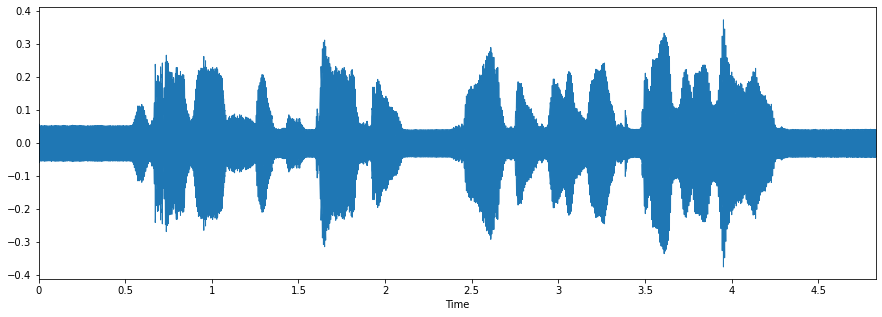

In [71]:

data, sampling_rate = librosa.load('output17.wav')

import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output17.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
livedf2
twodim= np.expand_dims(livedf2, axis=2)
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)
livepreds1=livepreds.argmax(axis=1)
liveabc = livepreds1.astype(int).flatten()
livepredictions = (lb.inverse_transform((liveabc)))
print(livepredictions)